# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [22]:
import sys
sys.path.append("..")

import os
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from model.llm import LLM
from model.transformer import CosinePositionalEncoding, RMSNorm, SwiGLU, SelfAttention, MultiHeadAttention, FeedForward, TransformerBlock

from model.tokenizer import Tokenizer, train_tokenizer

from model.dataset import NextTokenPredictionDataset

from model.trainer import train

# Model

In [4]:
bs, seq_len, dim_emb = 64, 32, 128
x = torch.randn((bs, seq_len, dim_emb))

## Check RMSNorm

In [5]:
rms_norm = RMSNorm(dim_emb)

print(f"total params: {sum(p.numel() for p in rms_norm.parameters())}")
print(f"learnable params: {sum(p.numel() for p in rms_norm.parameters() if p.requires_grad)}")
print(rms_norm)

with torch.no_grad():
    y = rms_norm(x)

print(f"{y.shape=}")

rms = torch.norm(x, dim=-1, keepdim=True) * (dim_emb**-0.5)
torch.allclose(x / rms, y)

total params: 128
learnable params: 128
RMSNorm()
y.shape=torch.Size([64, 32, 128])


True

## Check SwiGLU

In [6]:
swiglu = SwiGLU(dim_emb)

print(f"total params: {sum(p.numel() for p in swiglu.parameters())}")
print(f"learnable params: {sum(p.numel() for p in swiglu.parameters() if p.requires_grad)}")
print(swiglu)

with torch.no_grad():
    y = swiglu(x)
    
print(y.shape)

total params: 33024
learnable params: 33024
SwiGLU(
  (linear): Linear(in_features=128, out_features=256, bias=True)
)
torch.Size([64, 32, 128])


## Check positional encoding

total params: 0
learnable params: 0
CosinePositionalEncoding()
y.shape=torch.Size([64, 32, 128])


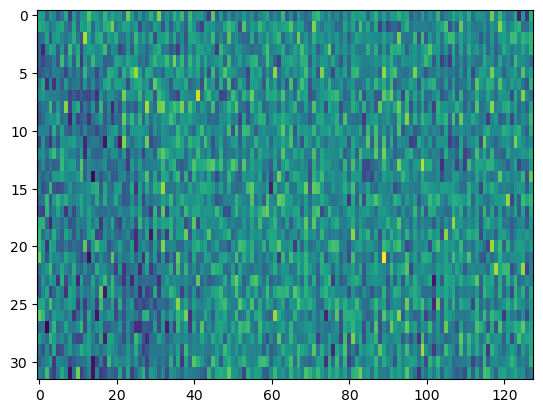

In [75]:
pos_encoding = CosinePositionalEncoding(seq_len, dim_emb)

print(f"total params: {sum(p.numel() for p in pos_encoding.parameters())}")
print(f"learnable params: {sum(p.numel() for p in pos_encoding.parameters() if p.requires_grad)}")
print(pos_encoding)

with torch.no_grad():
    y= pos_encoding(x)

print(f"{y.shape=}")

plt.imshow(y[0, ...], aspect="auto")

## Check self attention

total params: 65536
learnable params: 65536
SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


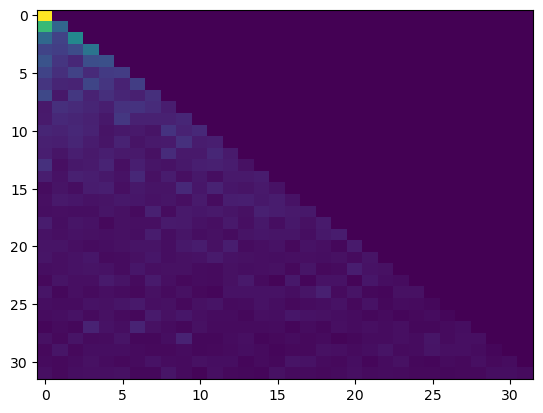

In [74]:
self_attn = SelfAttention(seq_len, dim_emb, causal=True)

print(f"total params: {sum(p.numel() for p in self_attn.parameters())}")
print(f"learnable params: {sum(p.numel() for p in self_attn.parameters() if p.requires_grad)}")
print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

SelfAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)


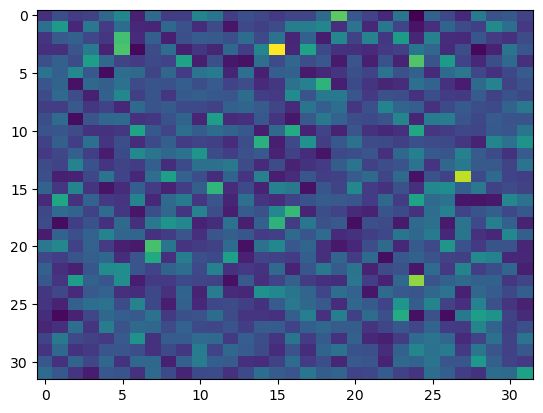

In [19]:
self_attn = SelfAttention(seq_len, dim_emb, causal=False)

print(self_attn)

with torch.no_grad():
    y, attn_scores = self_attn(x, return_scores=True)

plt.imshow(attn_scores[0, ...], aspect="auto")

## Check multihead attention

total params: 65536
learnable params: 65536
MultiHeadAttention(
  (projection_query): Linear(in_features=128, out_features=128, bias=False)
  (projection_key): Linear(in_features=128, out_features=128, bias=False)
  (projection_value): Linear(in_features=128, out_features=128, bias=False)
  (projection_out): Linear(in_features=128, out_features=128, bias=False)
)
torch.Size([64, 32, 128])
torch.Size([64, 2, 32, 32])


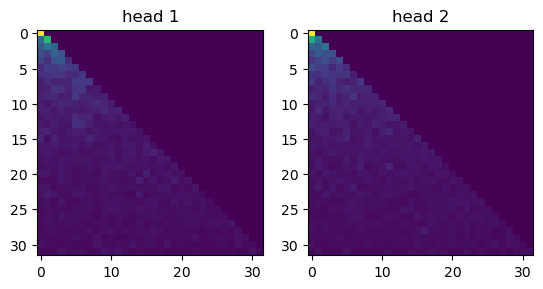

In [88]:
mha = MultiHeadAttention(seq_len, num_heads=2, dim_emb=dim_emb, causal=True)

print(f"total params: {sum(p.numel() for p in mha.parameters())}")
print(f"learnable params: {sum(p.numel() for p in mha.parameters() if p.requires_grad)}")
print(mha)

with torch.no_grad():
    y, attn_scores = mha(x, return_scores=True)


print(y.shape)
print(attn_scores.shape)

fig, axes = plt.subplots(1, mha.num_heads)

for h in range(mha.num_heads):
    axes[h].imshow(attn_scores[0, h, ...], aspect="equal")
    axes[h].set_title(f"head {h+1}")

## Check feedforward

In [72]:
ffd = FeedForward(dim_emb, dim_emb, num_hidden=2)

print(f"total params: {sum(p.numel() for p in ffd.parameters())}")
print(f"learnable params: {sum(p.numel() for p in ffd.parameters() if p.requires_grad)}")
print(ffd)

with torch.no_grad():
    y = ffd(x)

print(x.shape)
print(y.shape)

total params: 66304
learnable params: 66304
FeedForward(
  (_layers): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): RMSNorm()
    (2): SwiGLU(
      (linear): Linear(in_features=128, out_features=256, bias=True)
    )
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=128, out_features=128, bias=True)
  )
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## Check Transformer block

In [71]:
transformer = TransformerBlock(seq_len, dim_emb, attn_num_heads=2, attn_causal=True)

print(f"total params: {sum(p.numel() for p in transformer.parameters())}")
print(f"learnable params: {sum(p.numel() for p in transformer.parameters() if p.requires_grad)}")
print(transformer)

with torch.no_grad():
    y = transformer(x)

print(x.shape)
print(y.shape)

total params: 132352
learnable params: 132352
TransformerBlock(
  (pos_encoding): CosinePositionalEncoding()
  (norm_1): RMSNorm()
  (multihead_attn): MultiHeadAttention(
    (projection_query): Linear(in_features=128, out_features=128, bias=False)
    (projection_key): Linear(in_features=128, out_features=128, bias=False)
    (projection_value): Linear(in_features=128, out_features=128, bias=False)
    (projection_out): Linear(in_features=128, out_features=128, bias=False)
  )
  (norm_2): RMSNorm()
  (feed_forward): FeedForward(
    (_layers): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): RMSNorm()
      (2): SwiGLU(
        (linear): Linear(in_features=128, out_features=256, bias=True)
      )
      (3): Dropout(p=0.0, inplace=False)
      (4): Linear(in_features=128, out_features=128, bias=True)
    )
  )
)
torch.Size([64, 32, 128])
torch.Size([64, 32, 128])


## Check LLM

In [70]:
vocab_size = 1000
probs = torch.repeat_interleave(torch.Tensor([1 / vocab_size] * vocab_size).unsqueeze(0), 64, dim=0)
sequences = torch.multinomial(input=probs, num_samples=seq_len, replacement=True)

llm = LLM(vocab_size=vocab_size, context_size=seq_len, dim_emb=dim_emb, num_layers=2, attn_num_heads=2, attn_causal=True)

print(f"total params: {sum(p.numel() for p in llm.parameters())}")
print(f"learnable params: {sum(p.numel() for p in llm.parameters() if p.requires_grad)}")
print(llm)

with torch.no_grad():
    y = llm(sequences)

print(x.shape)
print(y.shape)

# Llama 7B has the following config: num_layer=32, num_head=32, dim_emb=4096),

total params: 521704
learnable params: 521704
LLM(
  (token_embedding): Embedding(1000, 128)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=128, out_features=128, bias=False)
        (projection_key): Linear(in_features=128, out_features=128, bias=False)
        (projection_value): Linear(in_features=128, out_features=128, bias=False)
        (projection_out): Linear(in_features=128, out_features=128, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=128, out_features=128, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=128, out_features=256, bias=True)
          )
          (3): Dropout(p=0.0, inplace=False)
          (4)

# Tokenizer

In [61]:
input_file = "../data/shakespeare/alllines.txt"
vocab_size = 1024
output_path = "../data/shakespeare"

tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file):
    train_tokenizer(input_file, vocab_size, tokenizer_model_file)
    
tokenizer = Tokenizer(tokenizer_model_file)

In [62]:
tokenizer.encode("Does it work?", end_of_string=True)

tensor([356, 103,  45, 773,  26,   2], dtype=torch.int32)

In [63]:
tokenizer.decode(tokenizer.encode("Does it work?")) == "Does it work?"

True

In [64]:
tokenizer.sp.EncodeAsPieces("Does it work?")

['▁Do', 'es', '▁it', '▁work', '?']

# Dataset

In [65]:
input_file = "../data/shakespeare/alllines.txt"
context_size = 8

ds_train = NextTokenPredictionDataset(input_file, context_size, tokenizer)

In [66]:
ds_train.get_batch(batch_size=8)

(tensor([[ 11,  10,   6, 306, 554,  10, 260,  77],
         [133,   4,   9, 209, 104,  47, 152,  19],
         [119,  16,   6, 453, 752, 668,  37, 183],
         [475,  31,   9, 261,  86,  45,   6, 361],
         [  4,  42, 747,  61,  43,  13, 195,  36],
         [  5,  50,  53,  57,  86, 435,  59,  40],
         [685,   4, 911, 998,  15, 341,  11,   5],
         [ 40,   4, 105,   9, 327,  53,  57,  36]], dtype=torch.int32),
 tensor([[ 10,   6, 306, 554,  10, 260,  77, 511],
         [  4,   9, 209, 104,  47, 152,  19,  48],
         [ 16,   6, 453, 752, 668,  37, 183, 740],
         [ 31,   9, 261,  86,  45,   6, 361, 230],
         [ 42, 747,  61,  43,  13, 195,  36,  73],
         [ 50,  53,  57,  86, 435,  59,  40, 129],
         [  4, 911, 998,  15, 341,  11,   5, 486],
         [  4, 105,   9, 327,  53,  57,  36, 270]]))

# Training

In [118]:
input_file = "../data/shakespeare/alllines.txt"
vocab_size = 4096
context_size = 64

dim_emb = 512
num_layers = 8
num_heads = 16

# tokenizer
rebuild_vocab=True
tokenizer_model_file = os.path.join(os.path.dirname(input_file), "tokenizer.model")
if not os.path.exists(tokenizer_model_file) or rebuild_vocab:
    train_tokenizer(input_file, vocab_size, tokenizer_model_file)

tokenizer = Tokenizer(tokenizer_model_file)

# training set
ds_train = NextTokenPredictionDataset(input_file, context_size, tokenizer)

# model
model = LLM(vocab_size=vocab_size, context_size=context_size, dim_emb=dim_emb, num_layers=num_layers, attn_num_heads=num_heads)

print(f"total params: {sum(p.numel() for p in model.parameters())}")
print(f"learnable params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")
print(model)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=../data/shakespeare/alllines.txt --vocab_size=4096 --model_prefix=../data/shakespeare/tokenizer --unk_id=0 --bos_id=1 --eos_id=2 --pad_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ../data/shakespeare/alllines.txt
  input_format: 
  model_prefix: ../data/shakespeare/tokenizer
  model_type: UNIGRAM
  vocab_size: 4096
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  har

total params: 21004288
learnable params: 21004288
LLM(
  (token_embedding): Embedding(4096, 512)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (pos_encoding): CosinePositionalEncoding()
      (norm_1): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (projection_query): Linear(in_features=512, out_features=512, bias=False)
        (projection_key): Linear(in_features=512, out_features=512, bias=False)
        (projection_value): Linear(in_features=512, out_features=512, bias=False)
        (projection_out): Linear(in_features=512, out_features=512, bias=False)
      )
      (norm_2): RMSNorm()
      (feed_forward): FeedForward(
        (_layers): Sequential(
          (0): Linear(in_features=512, out_features=512, bias=True)
          (1): RMSNorm()
          (2): SwiGLU(
            (linear): Linear(in_features=512, out_features=1024, bias=True)
          )
          (3): Linear(in_features=512, out_features=5

In [119]:
_, _ = train(model, ds_train, batch_size=128, lr=1e-4, max_steps=1000, log_every=10)

In [ ]:
out = model.generate(torch.zeros((1, context_size), dtype=torch.long), max_seq_len=50)
tokenizer.decode(out[:,context_size:])

'her nor more Iit Attendants English blood con for our Master mother conreS ski ski Iner more any entreat subject joy And drop blood furtherum wah mine return ANTIPHOLUS con Not strong France prove pur duke were need aboutGan heaven'